In [1]:
%matplotlib inline
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import googlemaps
import time
import numpy as np
import seaborn as sns


%config InlineBackend.figure_format = 'svg';

## Load and pre-process MTA data
metadata: http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt

In [3]:
# Use MTA data from March to June 2018
dict_data = {}
dfs = pd.DataFrame()

dates = ['180303','180310','180317','180324','180331','180407','180414','180421','180428','180505','180512','180519','180526','180602','180609','180616','180623','180630']

'''
# Load over URL, may take some time
for i, date in zip(range(len(dates)), dates):
    dict_data[i] = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'.format(date))
    dfs = dfs.append(dict_data[i])
'''

'''
# ALternatively, download the files and load from local directory
for date in dates:
    dfs = dfs.append(pd.read_csv('./data/raw/turnstile_{}.txt'.format(date)))
'''

In [8]:
# Remove extra space in column names
dfs.rename(columns={column : column.strip() for column in dfs.columns}, inplace = True)

dfs['DATE_TIME'] = pd.to_datetime(dfs.DATE + ' ' + dfs.TIME, format = '%m/%d/%Y %H:%M:%S')

# Check if there are duplicate entries for each device reading audit
(dfs.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
.ENTRIES.count()
.reset_index()
.sort_values('ENTRIES', ascending = False)
.head())

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
1205868,N183,R415,00-00-00,BROAD CHANNEL,2018-04-04 05:00:00,2
2213922,R101,R001,02-00-05,SOUTH FERRY,2018-05-23 09:00:00,2
2330235,R135,R031,01-00-00,34 ST-PENN STA,2018-03-22 08:00:00,2
3180387,R511,R091,00-00-00,36 AV,2018-06-21 16:00:00,2
2211591,R101,R001,02-00-02,SOUTH FERRY,2018-05-23 09:00:00,2


In [10]:
# Get rid of the duplicate entry
dfs.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)
dfs.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

## Retrieve zip code of MTA stations with googlemap API

In [12]:
# Replace key with Googlemap API developer key
# https://github.com/googlemaps/google-maps-services-python

gmaps = googlemaps.Client(key='xxxxxxxxx')

In [16]:
## Find zip code for each station
station_names = dfs.STATION.unique()

station_geo = {}
station_zipcode = {}

for station in station_names:
    place_id = gmaps.geocode('{} station, New York, NY'.format(station))[0]['place_id']
    response = gmaps.reverse_geocode(place_id)
    station_geo[station] = (response[0]['geometry']['location']['lat'], response[0]['geometry']['location']['lng'])
    station_zipcode[station] = response[0]['address_components'][len(response[0]['address_components'])-1]['long_name']

In [24]:
# Check the cases where zip code is not retrieved 

def checknullzip(station_zipcode):
    df_station = pd.DataFrame(list(station_zipcode.items()), columns = ['station', 'zipcode'])
    nullziplist = {}
    for i in range(df_station.shape[0]):
        if (not df_station.iloc[i,1].isdigit()):
            nullziplist[df_station.iloc[i,0]] = df_station.iloc[i,1]
    return len(nullziplist.keys())

checknullzip(station_zipcode)

0

In [22]:
# Reverse lookup with geospatial information to retrieve zip code
for station in nullziplist:
    response = gmaps.reverse_geocode(station_geo[station])
    station_zipcode[station] = response[0]['address_components'][len(response[0]['address_components'])-1]['long_name']
    time.sleep(2)
    
checknullzip(station_zipcode)

In [112]:
# Validate the zip codes
df_station = pd.DataFrame(list(station_zipcode.items()), columns = ['station', 'zipcode'])
df_station['zipcheck']=df_station.zipcode.apply(lambda x:len(x))
df_station[df_station['zipcheck']!=5]

# Manually fix the zip codes for the 7 stations with 4 digit zip codes by checking gmaps.geocode(station 'station, New York, NY')

,station,zipcode,zipcheck
51,FLATBUSH AV-B.C,3259,4
101,BOWERY,2811,4
118,PRINCE ST,3209,4
151,NEWARK BM BW,2810,4
295,NEWARK HM HE,2810,4
317,HOWARD BCH JFK,3529,4
331,NEWARK HW BMEBE,2810,4


In [136]:
df_station.drop('zipcheck', axis=1, inplace=True )

## Calculate entry traffic between 6AM and 12 PM

In [29]:
# Resample and interpolate entrance traffic count every 6 Hours
dfs.set_index('DATE_TIME', inplace=True)
dfs_resample = dfs.groupby(['C/A', 'UNIT', 'STATION', 'SCP'], as_index = False).apply(lambda df1: df1.resample('6H')
                                                              .first()
                                                             .interpolate())
# option to set as_index=False to avoid necessity to strip the index later

In [80]:
# Retain only traffic reading at 6AM and 12PM
dfs_resample.reset_index(inplace = True)
dfs_resample['TIME'] = pd.to_datetime(dfs_resample['DATE_TIME']).dt.hour
dfs_morning = dfs_resample[(dfs_resample['TIME'] == 6) | (dfs_resample['TIME'] == 12)]

In [81]:
# Combine all the readings 
dfs_morning = (dfs_morning.sort_values(by=['STATION', 'DATE_TIME'])
               .groupby(['STATION', 'DATE_TIME'])['ENTRIES']
               .sum()
               .reset_index())
dfs_morning['DATE'] = pd.to_datetime(dfs_morning['DATE_TIME']).apply(lambda x:x.date())

In [83]:
# Calculate morning entries by subtracting 6AM readings from 12PM reading
dfs_morning[["PREV_DATE", "PREV_ENTRIES"]] = (dfs_morning
                                                    .groupby(["STATION", "DATE"])['DATE','ENTRIES']
                                                    .transform(lambda grp: grp.shift(1)))
dfs_morning.dropna(inplace=True)
dfs_morning['ENTRIES_MORNING'] = dfs_morning['ENTRIES'] - dfs_morning['PREV_ENTRIES']

In [84]:
# Replace the negative values with average values
dfs_morning.loc[dfs_morning['ENTRIES_MORNING']<=0, 'ENTRIES_MORNING'] = dfs_morning.ENTRIES_MORNING.quantile(.5)

[9900, 10000, None, None]

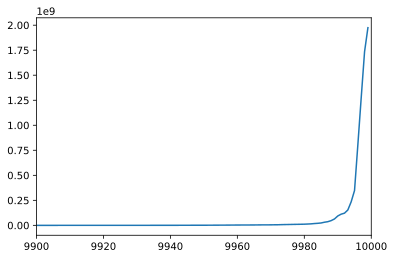

In [85]:
# Check the extreme values
for i in range(0, 10000):
    dfs_quantile[i] = dfs_morning.ENTRIES_MORNING.quantile(i/10000)
plt.plot(range(0,10000), dfs_quantile)
plt.axis([9900, 10000, None, None])

In [86]:
# Sort the morning traffic and observe a cutoff point to classify the extreme value as erroneous
dfs_morning.sort_values(by='ENTRIES_MORNING', ascending = False).head(50)
threshold = 100000
dfs_morning.loc[dfs_morning['ENTRIES_MORNING']>threshold, 'ENTRIES_MORNING'] = dfs_morning.ENTRIES_MORNING.quantile(.5)

In [87]:
# Get the top 5 stations by traffic
traffic_by_station = (dfs_morning
                      .groupby('STATION')
                      .ENTRIES_MORNING.mean()
                      .reset_index()
                      .sort_values('ENTRIES_MORNING', ascending = False)
                      .head(5))

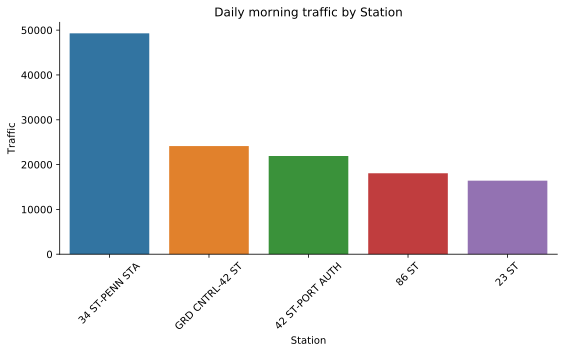

In [225]:
top5 = sns.factorplot('STATION', 'ENTRIES_MORNING', data = traffic_by_station, kind = 'bar', aspect = 2)
plt.xticks(rotation=45)
plt.xlabel('Station')
plt.ylabel('Traffic')
plt.title("Daily morning traffic by Station")

top5.savefig('./figures/top10traffic.png')
dfs_morning.to_csv('./data/processed/morningEntries.csv', index=False)

## Load census data and merge with 
https://blog.cubitplanning.com/2013/03/where-to-find-the-most-current-us-zip-code-income-data/

In [89]:
filepath = './data/raw/ACS_16_5YR_S1901_with_ann.csv'
census = pd.read_csv(filepath, index_col=False)

In [90]:
# This piece shows how the data is structured
colnames = ['GEO.id2', 'HC01_EST_VC02', 'HC01_EST_VC06', 'HC01_EST_VC07', 'HC01_EST_VC08', 'HC01_EST_VC09', 'HC01_EST_VC10', 'HC01_EST_VC11']
wealthy = census[colnames]
colnames = wealthy.iloc[0,:]
colnames[0] = 'zipcode'
wealthy.rename(columns=colnames, inplace=True)
wealthy = wealthy.iloc[1:,:]

In [105]:
# For data processing, we are only interested in income group between 150k and 200k
# We assume income group above 200k is unlikely to take subway
colnames = ['GEO.id2', 'HC01_EST_VC10']
wealthy = census[colnames]
wealthy.rename(columns={'GEO.id2': 'zipcode', 'HC01_EST_VC10': 'betw150kand200k'}, inplace = True)
wealthy = wealthy.loc[1:,]

/Users/songlin/anaconda2/envs/Python35/lib/python3.5/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [137]:
# Merge the station data with census income group data
census_zip = df_station.merge(wealthy, left_on=['zipcode'], right_on=['zipcode'],  how='left')
nan_rows = census_zip[census_zip['betw150kand200k'].isnull()]
census_zip.dropna(inplace = True)

In [163]:
# check which entries of betw150kand200k cannot be converted to float
for i in range(census_zip.shape[0]):
    try:
        census_zip.iloc[i,2] = float(census_zip.iloc[i,2])
    except ValueError:
        print('Error on line', i)
        
# Manually set those entries to 0
census_zip['betw150kand200k'] = census_zip['betw150kand200k'].astype(float)

In [166]:
# Merge the morning traffic avg with census data
mta_avg = dfs_morning.groupby(by = 'STATION').ENTRIES_MORNING.mean().reset_index()
mta_census = mta_avg.merge(census_zip, left_on=['STATION'], right_on=['station'], how='left')
mta_census.drop('station', axis = 1, inplace = True)

In [215]:
# Get the top 10 stations by target traffic
mta_census.dropna(inplace=True)
mta_census['tragettraffic'] = mta_census['ENTRIES_MORNING']*mta_census['betw150kand200k']/100
target_by_station = mta_census.sort_values('tragettraffic', ascending=False).head(10)
target_by_station = target_by_station.reset_index()
target_by_station

,index,STATION,ENTRIES_MORNING,zipcode,betw150kand200k,tragettraffic
0,61,34 ST-PENN STA,49280.523810,10001,8.8,4336.686095
1,233,GRD CNTRL-42 ST,24135.579365,10017,12.3,2968.676262
2,68,42 ST-PORT AUTH,21920.293651,10036,9.1,1994.746722
3,110,86 ST,18061.269841,10028,9.5,1715.820635
4,46,23 ST,16410.880952,10011,10.2,1673.909857
5,226,FULTON ST,15561.888889,10038,10.6,1649.560222
6,59,34 ST-HERALD SQ,15897.246032,11003,10.0,1589.724603
7,353,TIMES SQ-42 ST,12257.984127,10018,12.3,1507.732048
8,86,59 ST COLUMBUS,10948.920635,10023,12.3,1346.717238
9,115,96 ST,13179.309524,10025,9.7,1278.393024


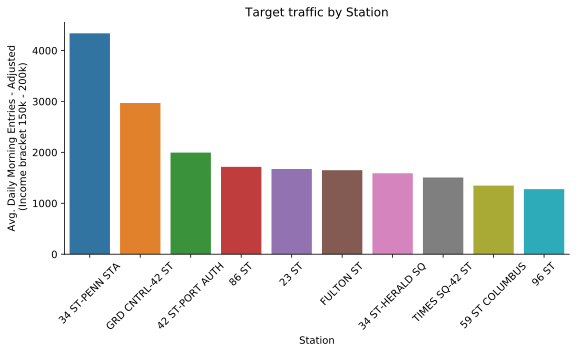

In [226]:
top10target = sns.factorplot('STATION', 'tragettraffic', data = target_by_station, kind = 'bar', aspect = 2)
plt.xticks(rotation=45)
plt.xlabel('Station')
plt.ylabel('Avg. Daily Morning Entries - Adjusted\n (Income bracket 150k - 200k)')
plt.title("Target traffic by Station")

top10target.savefig('./figures/top10tragettraffic.png')

In [202]:

# Calculate the morning traffic that fall under the income group for every station
targettraffic = dfs_morning.merge(census_zip, left_on=['STATION'], right_on=['station'], how='left')
targettraffic['targettraffic'] = targettraffic['ENTRIES_MORNING'] * targettraffic['betw150kand200k']/100

In [203]:
# Retrieve weekday and weekday name
targettraffic['weekday'] = targettraffic['DATE_TIME'].apply(lambda x:x.weekday())
targettraffic['weekdayname'] = targettraffic['DATE_TIME'].apply(lambda x:x.weekday_name)

In [213]:
mortraffic_byday = (targettraffic.groupby(('STATION', 'weekdayname'))
                     .mean()
                     .reset_index())

In [214]:
mortraffic_byday.head()

,STATION,weekdayname,ENTRIES,PREV_ENTRIES,ENTRIES_MORNING,betw150kand200k,targettraffic,weekday
0,1 AV,Friday,3.036715e+09,3.036710e+09,5379.833333,8.6,462.665667,4
1,1 AV,Monday,3.036631e+09,3.036626e+09,5113.888889,8.6,439.794444,0
2,1 AV,Saturday,3.036597e+09,3.036593e+09,3324.833333,8.6,285.935667,5
3,1 AV,Sunday,3.036614e+09,3.036612e+09,2348.111111,8.6,201.937556,6
4,1 AV,Thursday,3.036692e+09,2.893026e+09,5235.222222,8.6,450.229111,3


In [216]:
top3station = target_by_station.STATION.tolist()[0:3]

In [220]:
def dayofweek(df, stationlist):
    dayofweek=pd.DataFrame(['Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday'], columns=['weekdayname'])
    for station in stationlist:
        tmp = (df[df['STATION'] == station]
                     .groupby('weekdayname')
                     .mean()
                     .reset_index()
                     .sort_values('weekday')['targettraffic'])
        tmp = pd.DataFrame(tmp.tolist(), columns=[station])
        dayofweek = pd.concat([dayofweek, tmp], axis = 1)
    return dayofweek

In [224]:
top3target_byday = dayofweek(mortraffic_byday, top3station)
top3target_byday


,weekdayname,34 ST-PENN STA,GRD CNTRL-42 ST,42 ST-PORT AUTH
0,Monday,5114.467111,3464.691333,2406.454556
1,Tuesday,5736.734667,3652.949667,2474.396167
2,Wednesday,5767.730222,3678.069000,2175.269056
3,Thursday,5993.264444,3925.996000,2334.453333
4,Friday,4598.518222,3510.536167,2316.587000
5,Saturday,1706.471556,1485.020000,1253.024500
6,Sunday,1439.616444,1063.471667,1003.042444


In [ ]:
# Insert the plotting code here
plt.figure(figsize=(11,7))
x = np.array(range(7))

plt.subplot(1,1,1)
plt.bar(x-0.2, top3target_byday['34 ST-PENN STA'], width = 0.2, color = 'b', label='34 ST-PENN STA') #34 ST PENN
plt.bar(x, top3target_byday['GRD CNTRL-42 ST'], width = 0.2, color = 'g', label = 'GRD CNTRL-42 ST') # TIME SQUARE
plt.bar(x+0.2, top3target_byday['42 ST-PORT AUTH'], width = 0.2, color = 'y', label = '42 ST-PORT AUTH') #GRAND CENTRAL
plt.xticks(x, ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.legend(loc='upper right')
plt.xlabel('Day of Week')
plt.ylabel('Avg. Daily Morning Entries - Adjusted\n(Income Bracket $150k - $200k)')